In [204]:
import sys
import time
import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # http://www.numpy.org/
import tekwfm
import os
from os.path import exists
from scipy import signal
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.special import gamma
import matplotlib.cm as cm
from collections import Counter

import gc
import re
import tempfile
from collections import defaultdict, namedtuple
from pathlib import Path
import pandas as pd

In [205]:
doVerbose = False

#import the wfm file
#filename_base = "PMT1_rawdata/141125_darkrate_1850_10000_1_off"
filename_base = "PMT7_rawdata/020226_darkrate_1800_10000_2_on"


#saving the processed file
#folder_name = "PMT4_AllAnalysis/Test"
#file_name = "200126_darkrate_2000_10000_1_off_processed.csv" 
#file_path = os.path.join(os.getcwd(), folder_name, file_name)


startEvent = 540
nEvents = 100

# code here to pass arguments

volts, tstart, tscale, tfrac, tdatefrac, tdate = tekwfm.read_wfm(filename_base+".wfm")
if doVerbose:
    print('>>>>', volts, tstart, tscale, tfrac, tdatefrac, tdate)

samples = volts.shape

print(len(volts))
print(tscale)
print('samples', samples[0])
tstop = samples[0]*tscale+tstart
sampleTimes = [tstart+x*tscale for x in range(samples[0])]
sampleTimes = np.array(sampleTimes) * 1e9

negVolts = [volts[:, event] for event in range(startEvent, startEvent + nEvents)] # all events, array of array of voltages
#tempVolts = -1 * negVolts # makes pulses positive
tempVolts = [-v for v in negVolts]

1250
8e-11
samples 1250


In [206]:
"""variables which can be changed"""
baseline_end_frac = 0.15
amplitude_start_frac = 0
amplitude_end_frac = 0.6
pulse_end_frac = 0.99

timediffbins=1000 #number of bins in the histogram for time between each event
zoomedtimediffbins=10000 #number of bins in the zoomed in histogram for time between each event
zoom=0.0005 #the max x coordinate for zooming in on this histogram (looking at range 0 to 0.0005)


In [207]:
def calcbaseline(tempVolt, samples):
    baseline_voltages = tempVolt[0: int(baseline_end_frac*samples[0])]
    mean_b = np.mean(baseline_voltages)
    sigma_b = np.std(baseline_voltages, ddof=1)
    correct_tempVolt = tempVolt - mean_b
    return mean_b, sigma_b, correct_tempVolt

def calcamplitude(corrected_tempVolt, samples):
    #amplitude_voltages = corrected_tempVolt[int(amplitude_start_frac*samples[0]):int(amplitude_end_frac*samples[0])]
    threshold = 5 * sigma_b
    if threshold > 0.003 * 1e3 :
        min_height = 5 * sigma_b
    else:
        min_height = 0.003 * 1e3
    #min_height = 0.003
    min_separation = int(0.05*samples[0]) # have changed from 0.04
    prominance = 0.01 * 1e3# have changed from 0.025
    #peaks, _ = find_peaks(amplitude_voltages, height=min_height, distance=min_separation, prominence=prominance)
    peaks, properties = find_peaks(corrected_tempVolt, height=min_height, distance=min_separation, prominence=prominance)
    number_of_peaks = len(peaks)
    if len(peaks) > 0:
        amplitude = corrected_tempVolt[peaks[0]]
        #first_peak_index = peaks[0] + int(amplitude_start_frac*samples[0])
        first_peak_index = peaks[0]
        first_peak_time = sampleTimes[first_peak_index]

    else:

        amplitude = np.max(corrected_tempVolt)
        peak_index = np.argmax(corrected_tempVolt)
        first_peak_index = peak_index
        first_peak_time = sampleTimes[first_peak_index]
    #if amplitude > 0.005:
      # number_of_peaks = 1
        number_of_peaks = 1

    return amplitude, first_peak_index, first_peak_time, number_of_peaks, peaks

def peak_FWHM(corrected_tempVolt, amplitude, peak_index, sampleTimes):   
    half_maximum = amplitude/2
    
    #left crossing of half maximum
    left = peak_index #begin at index of peak
    #move left until voltage rises to half maximum, stopping if left>0 (beginning of window reached)
    while left>0 and corrected_tempVolt[left]>half_maximum:
        left -= 1 #index moves left
    #interpolate between left and left+1
    if left == 0: #if beginning of window reached, take first time value as left crossing
        left_time = sampleTimes[0]
    else: 
        y1, y2 = corrected_tempVolt[left], corrected_tempVolt[left+1]
        x1, x2 = sampleTimes[left], sampleTimes[left+1]
        left_time = x1 + (half_maximum - y1)/(y2-y1) * (x2-x1)
        
    #same again for right
    right = peak_index
    while right<len(corrected_tempVolt)-1 and corrected_tempVolt[right]>half_maximum:
        right += 1
    #interpolate between right and right-1
    if right == len(corrected_tempVolt)-1: #if end of window reached, take last time value as right crossing
        right_time = sampleTimes[-1]
    else: 
        y1, y2 = corrected_tempVolt[right], corrected_tempVolt[right-1]
        x1, x2 = sampleTimes[right], sampleTimes[right-1]
        right_time = x1 + (half_maximum - y1)/(y2-y1) * (x2-x1)
    
    singleFWHM = right_time - left_time
    return singleFWHM, left_time, right_time

def time_above_threshold(corrected, times, sigma_b, first_peak_index):
    threshold = 25 * sigma_b

    #  Find left crossing
    i = first_peak_index
    while i > 0 and corrected[i] > threshold:
        i -= 1

    # If the peak is below threshold, set left to the peak itself
    if corrected[first_peak_index] <= threshold:
        first_cross = times[first_peak_index]
    else:
        # Interpolate left crossing
        if i == 0:
            first_cross = times[0]
        else:
            y1, y2 = corrected[i], corrected[i + 1]
            x1, x2 = times[i], times[i + 1]
            if y2 - y1 == 0:
                first_cross = x1
            else:
                frac = (threshold - y1) / (y2 - y1)
                frac = max(0, min(1, frac))  # clip fraction to [0,1]
                first_cross = x1 + frac * (x2 - x1)

    # Find right crossing
    j = first_peak_index
    while j < len(corrected) - 1 and corrected[j] > threshold:
        j += 1

    if corrected[first_peak_index] <= threshold:
        second_cross = times[first_peak_index]
    else:
        if j == len(corrected) - 1:
            second_cross = times[-1]
        else:
            y1, y2 = corrected[j - 1], corrected[j]
            x1, x2 = times[j - 1], times[j]
            if y2 - y1 == 0:
                second_cross = x2
            else:
                frac = (threshold - y1) / (y2 - y1)
                frac = max(0, min(1, frac))
                second_cross = x1 + frac * (x2 - x1)

    # Compute time above threshold
    time_above = second_cross - first_cross
    if time_above < 0:
        time_above = 0  # fallback if something went wrong

    return time_above, first_cross, second_cross

def total_time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b):
    threshold = 25 * sigma_b
    if max(corrected_tempVolt) <= threshold:
        return None
    total_time = 0.0

    for i in range(len(corrected_tempVolt) - 1):
        v1 = corrected_tempVolt[i]
        v2 = corrected_tempVolt[i + 1]
        t1 = sampleTimes[i]
        t2 = sampleTimes[i + 1]
        dt = t2 - t1

        # Entire segment above threshold
        if v1 > threshold and v2 > threshold:
            total_time += dt

        # Rising through threshold
        elif v1 <= threshold and v2 > threshold:
            frac = (threshold - v1) / (v2 - v1)
            total_time += (1 - frac) * dt

        # Falling through threshold
        elif v1 > threshold and v2 <= threshold:
            frac = (threshold - v1) / (v2 - v1)
            total_time += frac * dt

        # Else: fully below threshold → add nothing

    return total_time if total_time > 0 else None

def calc_time_above_3sigma(corrected, times, sigma_b, mean_b, first_peak_index):
    threshold = mean_b + 3*sigma_b

    i = first_peak_index
    while i > 0 and corrected[i] > threshold:
        i -= 1
    # If we hit the boundary and are STILL above threshold → no crossing
    if i == 0 and corrected[i] > threshold:
        return None, None, None
    # Interpolate only if we actually crossed between i and i+1
    y1, y2 = corrected[i], corrected[i+1]
    x1, x2 = times[i], times[i+1]
    # Ensure interpolation makes physical sense
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):  
        return None, None, None
    first_3sigma_cross = x1 + frac * (x2 - x1)

    j = first_peak_index
    while j < len(corrected)-1 and corrected[j] > threshold:
        j += 1
    if j == len(corrected)-1 and corrected[j] > threshold:
        return None, None, None
    y1, y2 = corrected[j-1], corrected[j]
    x1, x2 = times[j-1], times[j]
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):
        return None, None, None
    second_3sigma_cross = x1 + frac * (x2 - x1)

    time_above_3sigma = second_3sigma_cross - first_3sigma_cross
    if time_above_3sigma <= 0:
        return None, None, None

    return time_above_3sigma, first_3sigma_cross, second_3sigma_cross
'''
#convert first crossing time to index to be used in integral
def time_index(first_crossing_time, sampleTimes):
    if first_crossing_time is None:
        return len(sampleTimes) - 1
    else:
        time_difference = np.abs(np.array(sampleTimes) - first_crossing_time)
        closest_index = np.argmin(time_difference)
        return closest_index
'''
def time_index(first_3sigma_cross, sampleTimes):
    if first_3sigma_cross is None:
        return len(sampleTimes) - 1
    else:
        time_difference = np.abs(np.array(sampleTimes) - first_3sigma_cross)
        closest_index = np.argmin(time_difference)
        return closest_index
        
#integrate a single event
def single_charge_integral(corrected_tempVolt, sampleTimes, closest_index):
    # define bound 1 and 2
    bound_1 = closest_index
    bound_2 = int(pulse_end_frac*len(corrected_tempVolt))
    integral_voltages = corrected_tempVolt[bound_1:bound_2]
    time_slice = sampleTimes[bound_1:bound_2]
    single_integral = integrate.trapezoid(integral_voltages, x=time_slice)
    #return a single number for the integral of one event
    return single_integral

def correcting_tempVolts(tempVolts, mean_b):
    corrected_tempVolts = []
    for i, tempVolt in enumerate(tempVolts):
        corrected = tempVolt - mean_b[i]
        corrected_tempVolts.append(corrected)
    return corrected_tempVolts

In [208]:
"""Working on all events"""
mean_b_array = []
sigma_b_array = []
corrected_tempVolts = []
all_amplitudes = []
all_peak_times = []
all_peak_indices = []
all_FWHM = []
all_t1 = []
all_t2 = []
all_time_above_thresh = []
all_total_time_above = []
all_first_crossing = []
all_second_crossing = []
all_tabove_3sig = []
all_first_t_3sig = []
all_second_t_3sig = []
all_closest_indices = []
all_integrals = []
all_number_of_peaks = []

for tempVolt in tempVolts:
    mean_b, sigma_b, corrected_tempVolt = calcbaseline(tempVolt, samples)
    mean_b_array.append(mean_b)
    sigma_b_array.append(sigma_b)
    corrected_tempVolts.append(corrected_tempVolt)

mean_b_array = np.array(mean_b_array) * 1e3
sigma_b_array = np.array(sigma_b_array) * 1e3
corrected_tempVolts = np.array(corrected_tempVolts) * 1e3

In [209]:
def debug_plot_pulse(corrected, sampleTimes, mean_b, sigma_b, first_peak_index, event_index, peaks):
    threshold = mean_b + 5*sigma_b

    plt.figure(figsize=(10, 4))
    plt.plot(sampleTimes, corrected, label="Pulse")
    plt.axhline(threshold, color='r', linestyle='--', label='5σ threshold')
    plt.axvline(sampleTimes[first_peak_index], color='g', linestyle=':', label='Peak')
    for p in peaks:
        plt.axvline(sampleTimes[p], color='orange', linestyle=':', alpha=0.6)
    plt.title(f"Event {event_index}")
    plt.xlabel("Time (ns)")
    plt.ylabel("Voltage (mV)")
    plt.legend()
    plt.grid(True)
    plt.show()

def full_annotations(corrected, sampleTimes, mean_b, sigma_b, first_peak_index, event_index, amplitude, first_3sigma_cross, peaks):
    threshold = 27*sigma_b
    t_start, t_end = first_3sigma_cross, 80
    #mask = (sampleTimes >= t_start) & (sampleTimes <= t_end)
    x_start = sampleTimes[0]
    x_end = sampleTimes[int(0.15 * len(sampleTimes))]  # first 15% of the time axis


    plt.figure(figsize=(10, 6))
    plt.plot(sampleTimes, corrected, color='black', label="Pulse")
    #plt.axhline(mean_b, color='black', linestyle = '-', label='Mean Baseline')
    plt.axhline(threshold, color='b', linestyle='--', label='11σ Threshold')
    plt.axvline(sampleTimes[first_peak_index], color='g', linestyle=':')
    for p in peaks:
        plt.axvline(sampleTimes[p], color='g', linestyle=':', alpha=0.6)
    #plt.axhline(amplitude + mean_b, color='g', linestyle=':', label='Amplitude' )
    plt.axhline(amplitude, color='g', linestyle=':', label='Peak Amplitude and Time Location' )
    plt.axhline(sigma_b, color='b', linestyle='-', label='Standard Deviation of Baseline (σ)')
    #plt.axvspan(t_start, t_end, color='green', alpha=0.05, label='Integration interval')
    plt.axhline(3*sigma_b, color='r', linestyle=':', label='3σ Threshold Voltage and Time Location')
    if first_3sigma_cross is not None:
        plt.axvline(first_3sigma_cross, color='r', linestyle=':')
    # Shade only under the curve in this interval
    #plt.fill_between(sampleTimes[mask], corrected[mask], color='green', alpha=0.3, label='Integration interval')
    start_idx = np.searchsorted(sampleTimes, t_start)
    end_idx = np.searchsorted(sampleTimes, t_end)

# Shade under the curve only in that interval
    plt.fill_between(
        sampleTimes[start_idx:end_idx],
        corrected[start_idx:end_idx],
        0,
        color='magenta',
        alpha=0.2,
        label='Integration region'
    )
    '''
    # Draw horizontal line at baseline
    plt.hlines(
        y=-0.001,      # y-value of the line
        xmin=x_start, 
        xmax=x_end, 
        color='blue', 
        linewidth=2,
        label='Baseline region'
    )
    '''
    plt.axvspan(
    x_start, 
    x_end, 
    color='blue', 
    alpha=0.05, 
    label='Baseline region'
)
    plt.title(f"Event {event_index}")
    plt.xlabel("Time (ns)")
    plt.ylabel("Voltage (mV)")
    plt.xlim(-20, 80)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)
    plt.show()

time_above: 3.015824023001251
total_time 3.0158240230012505
first_crossing_time: -0.5127960246009182
second_crossing_time: 2.5030279984003325
Number of peaks: 1


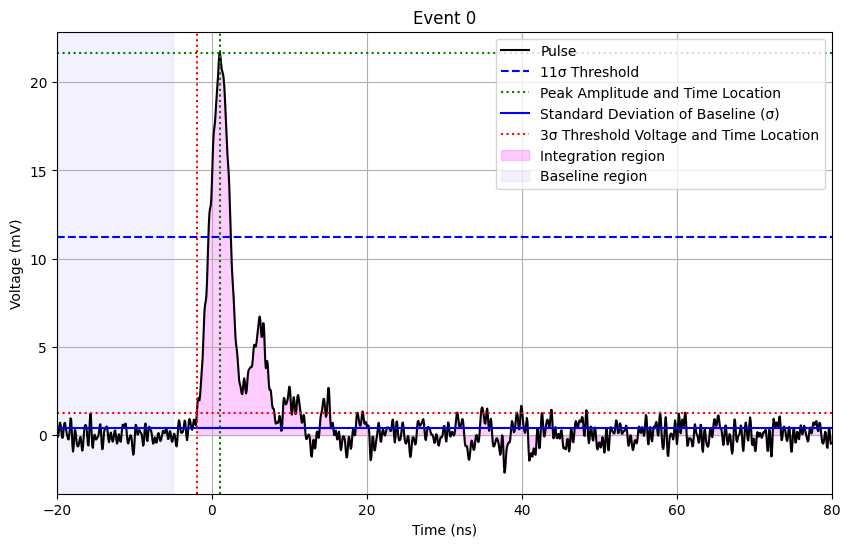

time_above: 2.5197314150549737
total_time 2.5197314150549737
first_crossing_time: -0.4618660320482628
second_crossing_time: 2.057865383006711
Number of peaks: 1


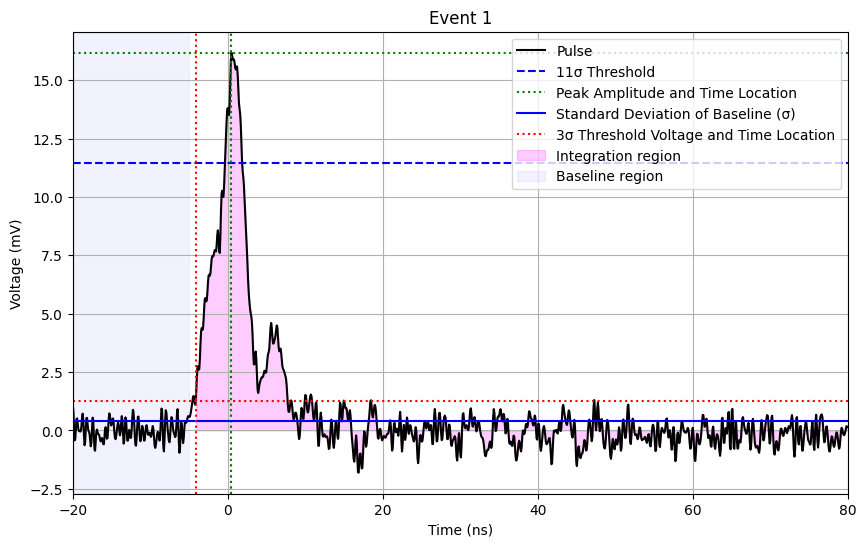

time_above: 3.942166686296176
total_time 3.942166686296176
first_crossing_time: -0.39273183412426305
second_crossing_time: 3.5494348521719132
Number of peaks: 1


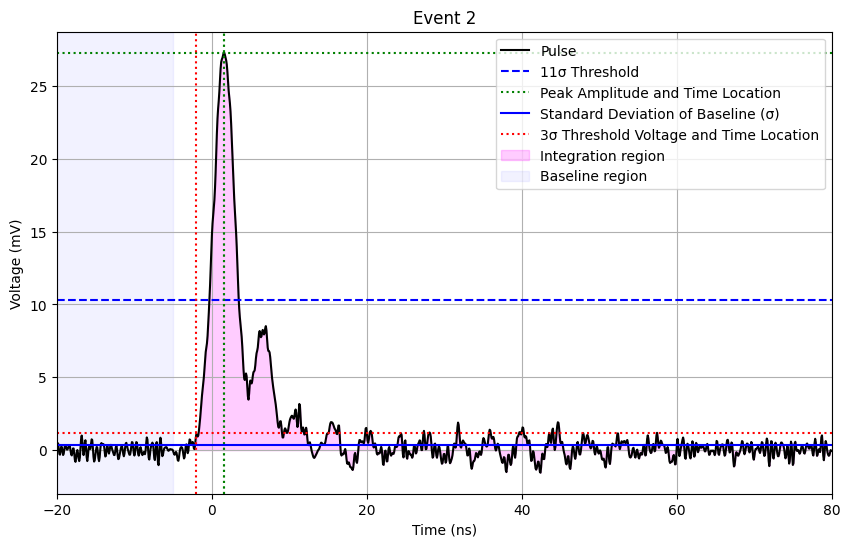

time_above: 0.0
total_time None
first_crossing_time: 0.39999999999999697
second_crossing_time: 0.39999999999999697
Number of peaks: 1


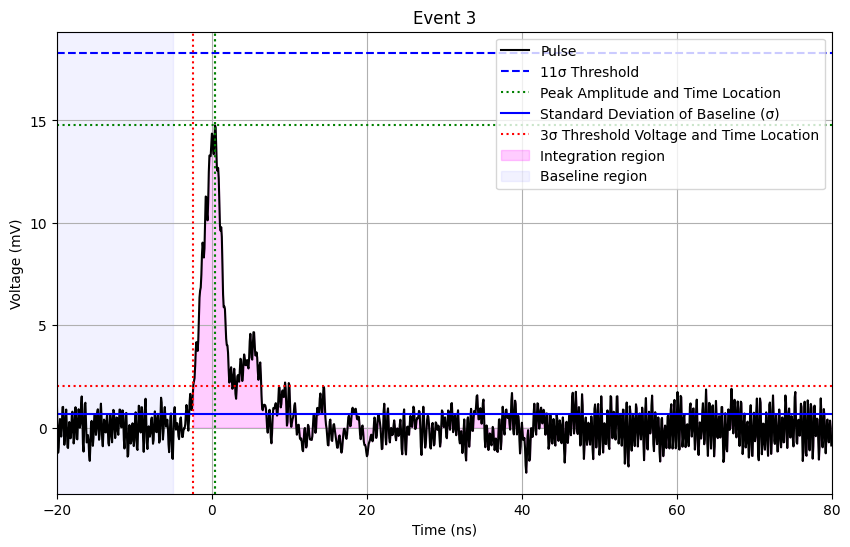

time_above: 10.066074592142025
total_time 10.696604813230053
first_crossing_time: -0.21280935155350664
second_crossing_time: 9.853265240588518
Number of peaks: 1


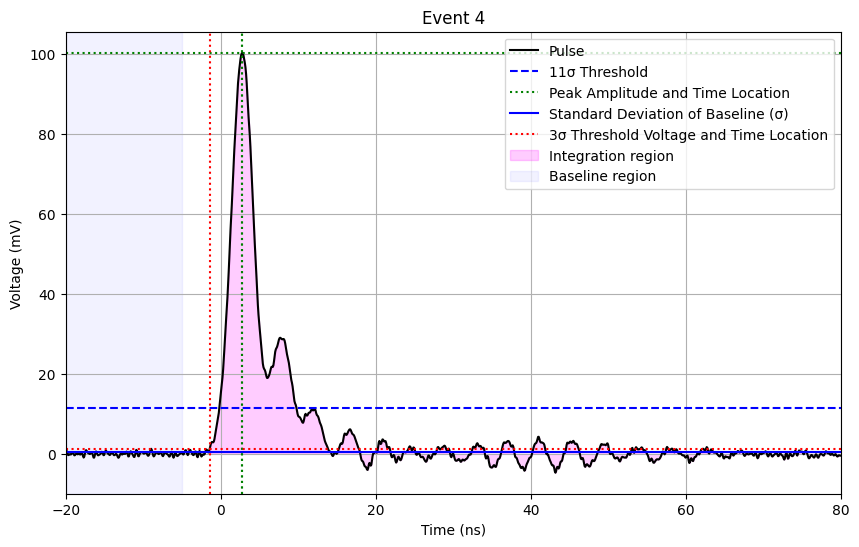

time_above: 10.396767451071739
total_time 12.280996482177306
first_crossing_time: -0.23879889296956988
second_crossing_time: 10.15796855810217
Number of peaks: 4


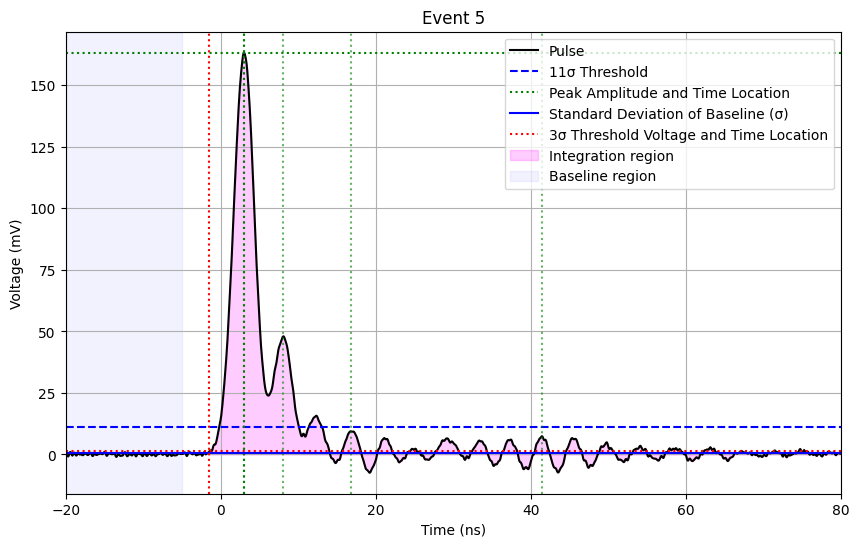

time_above: 1.8083250830010682
total_time 1.8083250830010682
first_crossing_time: -0.9559491417227431
second_crossing_time: 0.852375941278325
Number of peaks: 1


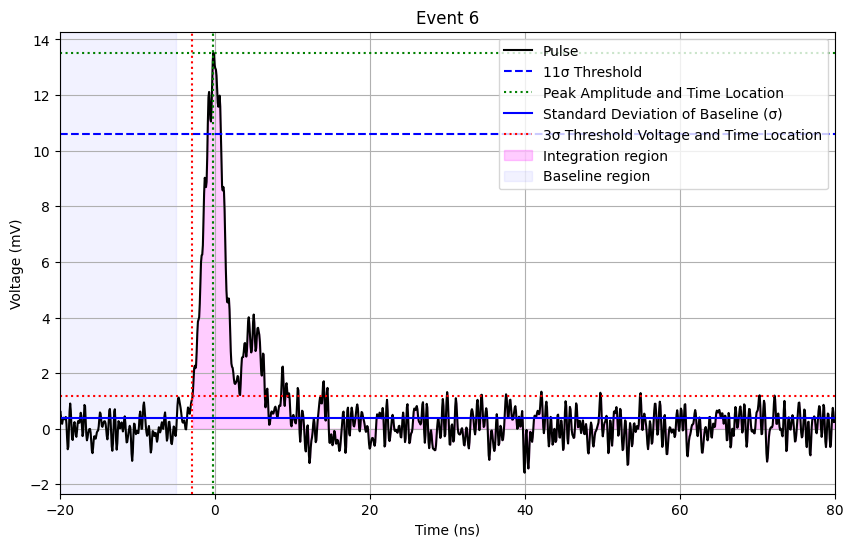

time_above: 0.0
total_time None
first_crossing_time: 0.6399999999999978
second_crossing_time: 0.6399999999999978
Number of peaks: 1


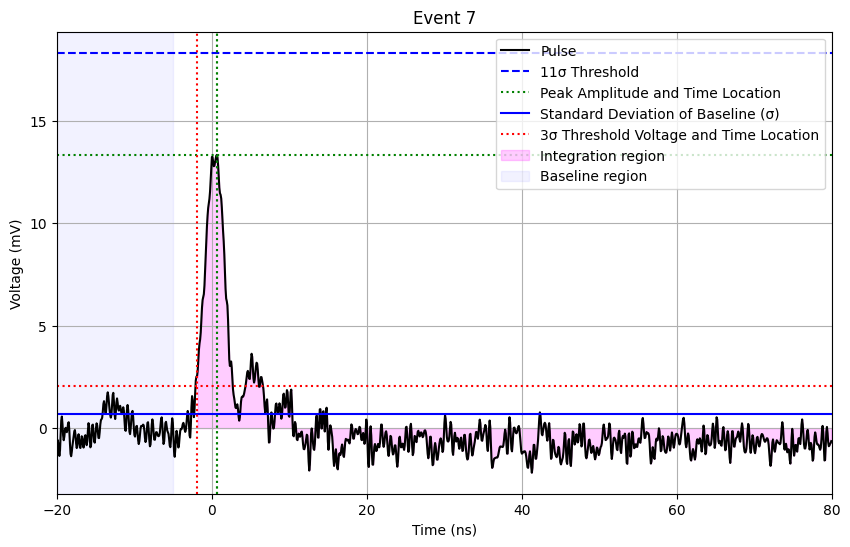

time_above: 0.0
total_time None
first_crossing_time: 0.4799999999999983
second_crossing_time: 0.4799999999999983
Number of peaks: 1


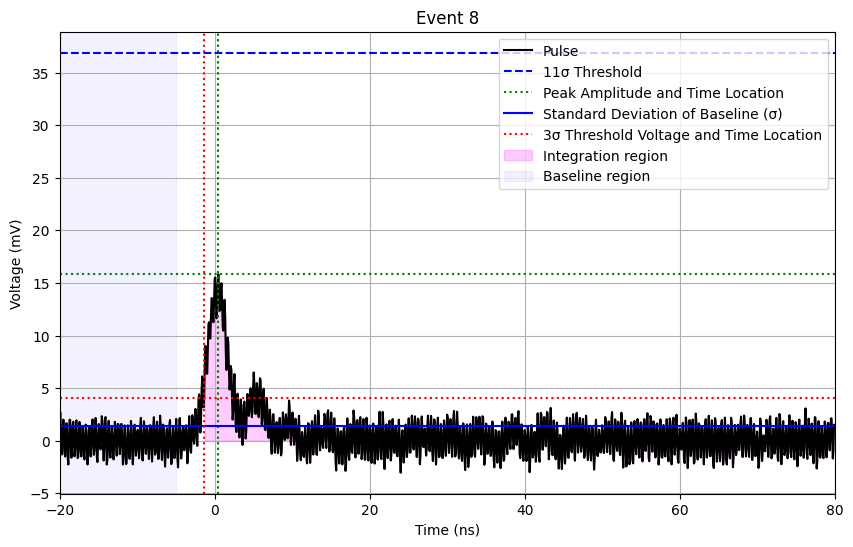

time_above: 0.0
total_time None
first_crossing_time: 0.7999999999999973
second_crossing_time: 0.7999999999999973
Number of peaks: 1


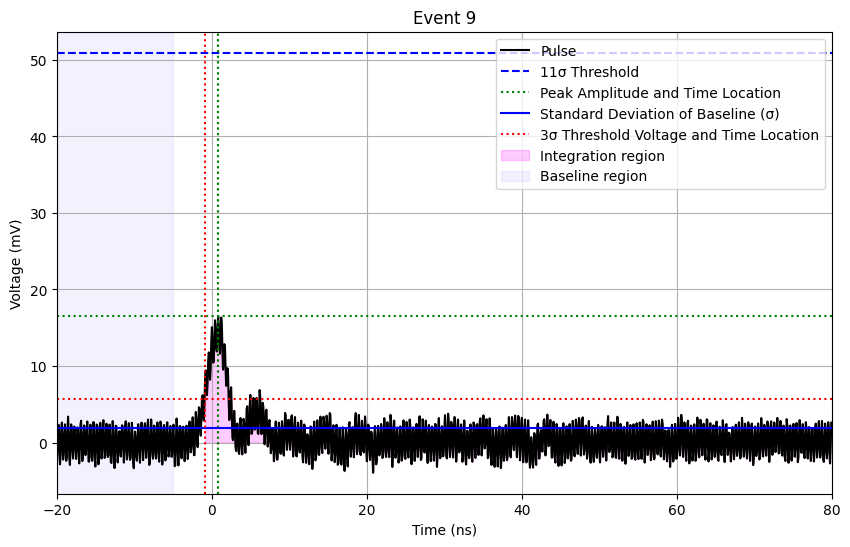

time_above: 1.8465973748286784
total_time 1.8465973748286784
first_crossing_time: -0.7801823024735692
second_crossing_time: 1.0664150723551091
Number of peaks: 1


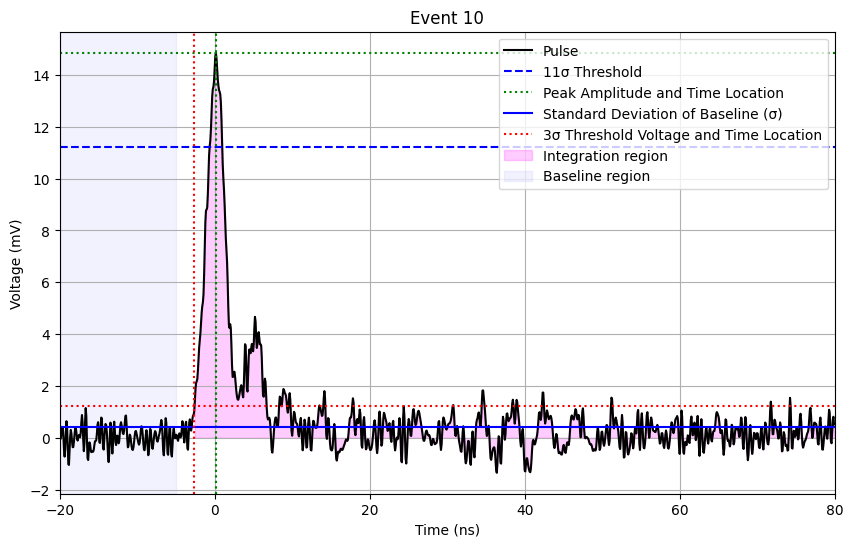

time_above: 1.5396042451664886
total_time 1.5396042451664886
first_crossing_time: -0.38706222874317364
second_crossing_time: 1.152542016423315
Number of peaks: 1


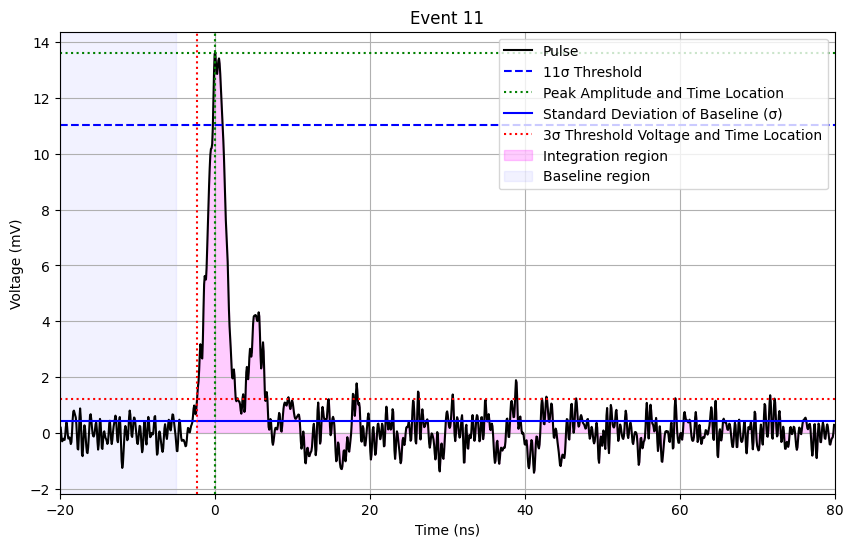

time_above: 2.5260464948908847
total_time 2.5260464948908843
first_crossing_time: -0.3943580280889326
second_crossing_time: 2.1316884668019522
Number of peaks: 1


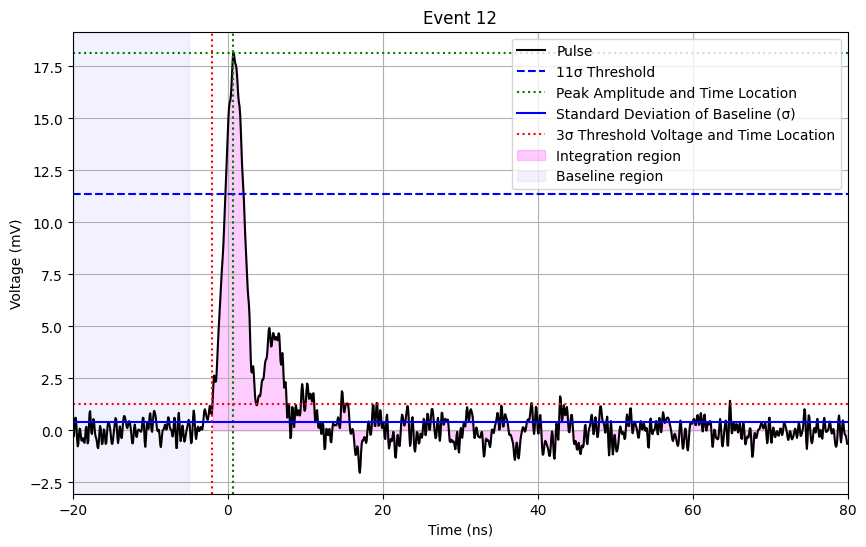

time_above: 1.9004336735636236
total_time 1.9004336735636236
first_crossing_time: 0.01472622378467318
second_crossing_time: 1.9151598973482968
Number of peaks: 1


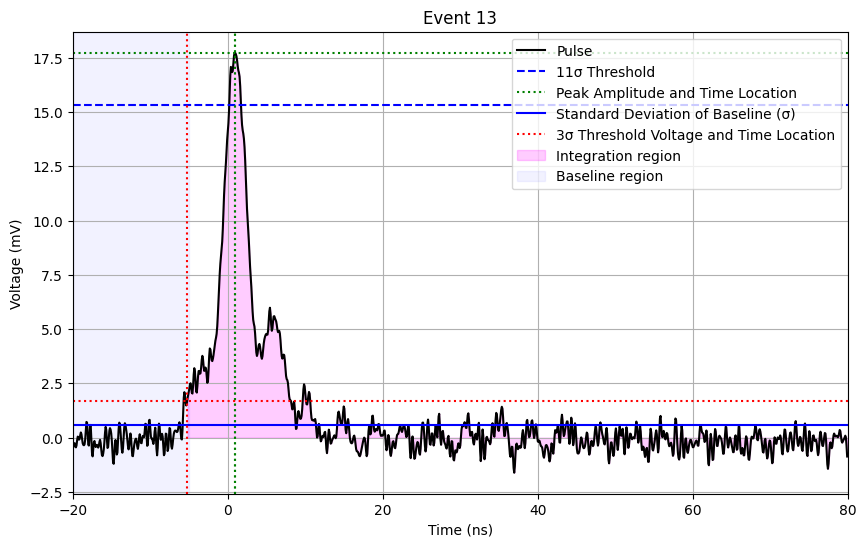

time_above: 5.1944050177553835
total_time 5.194405017755384
first_crossing_time: -0.133868078186808
second_crossing_time: 5.060536939568576
Number of peaks: 1


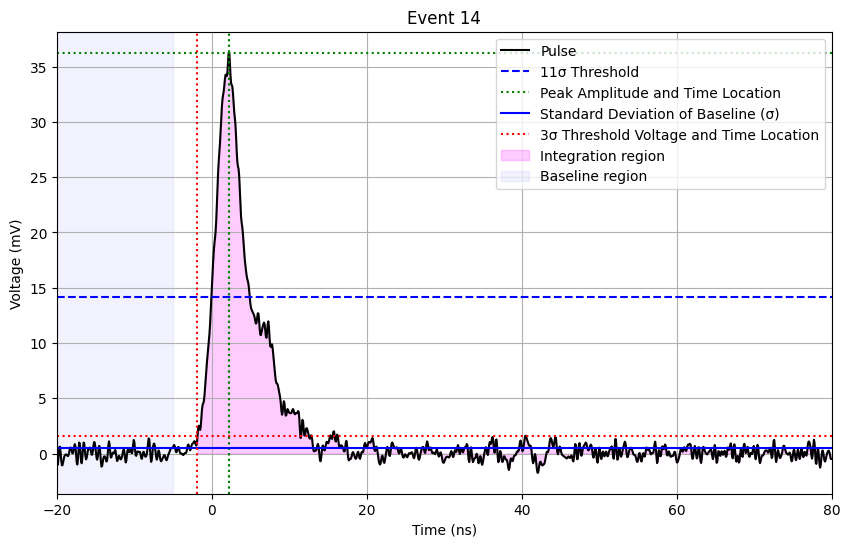

time_above: 3.1291968381034256
total_time 3.1291968381034256
first_crossing_time: -0.8242587408616067
second_crossing_time: 2.304938097241819
Number of peaks: 1


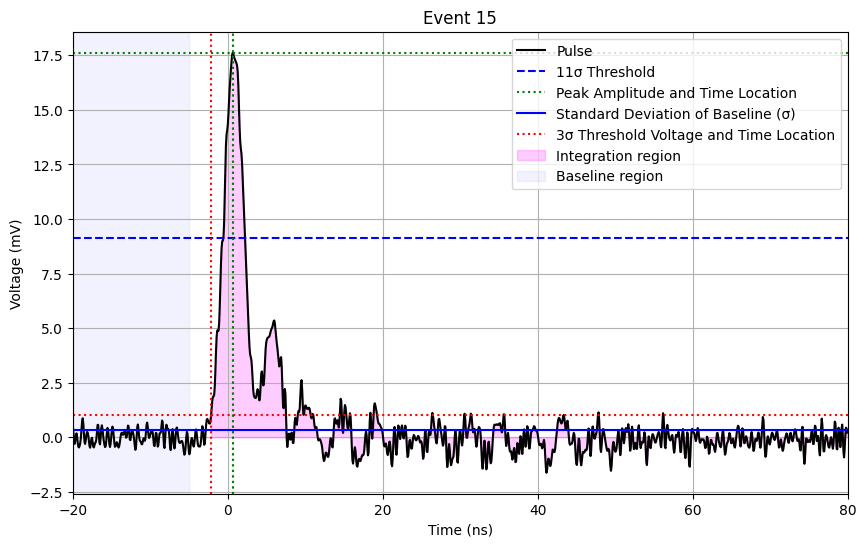

time_above: 2.1720185171408852
total_time 2.172018517140885
first_crossing_time: -0.5828134447730339
second_crossing_time: 1.5892050723678515
Number of peaks: 1


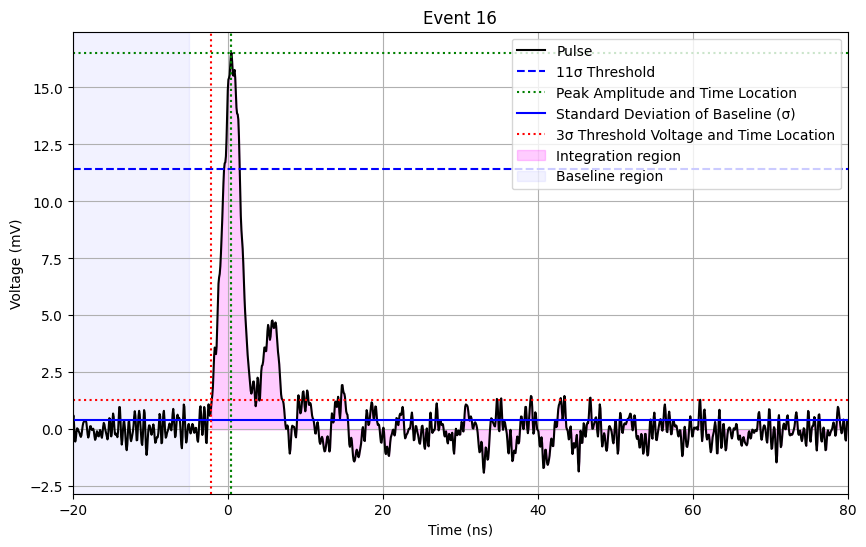

time_above: 4.604293061999113
total_time 6.604805789163993
first_crossing_time: -0.37088733595805257
second_crossing_time: 4.2334057260410605
Number of peaks: 1


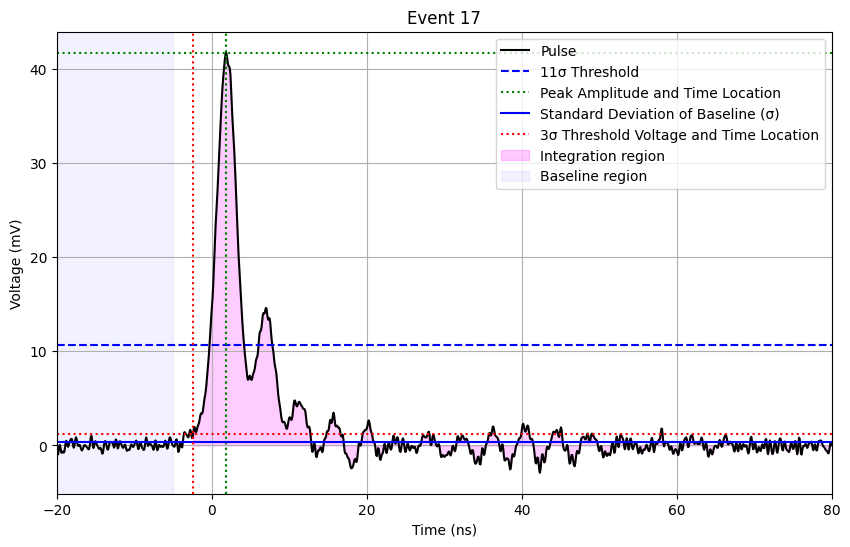

time_above: 9.616348375709693
total_time 9.616348375709698
first_crossing_time: -0.45592751402598014
second_crossing_time: 9.160420861683713
Number of peaks: 1


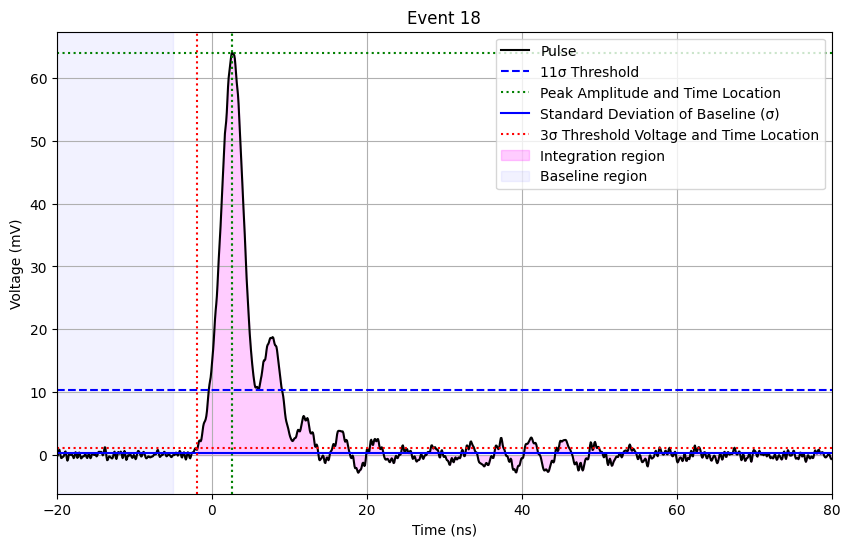

time_above: 3.761808901415236
total_time 3.7618089014152365
first_crossing_time: -0.5575575155480703
second_crossing_time: 3.204251385867166
Number of peaks: 1


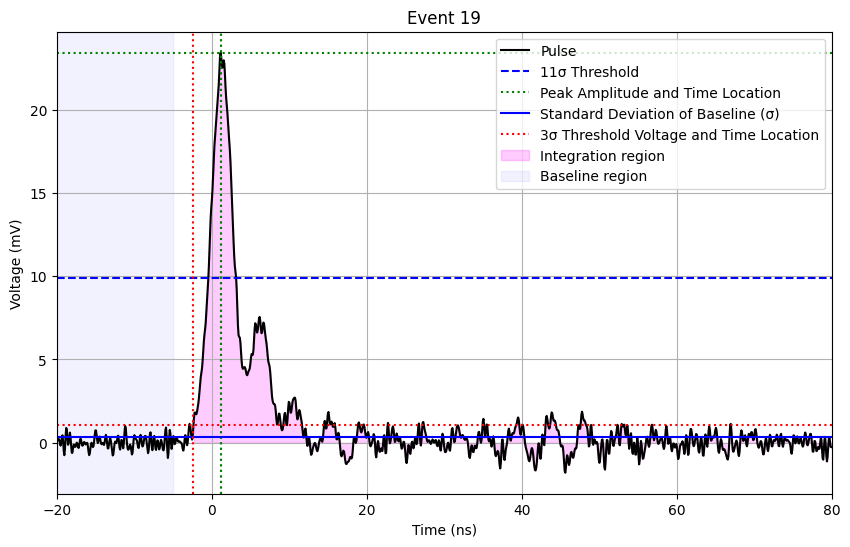

In [210]:
for event_index, corrected_tempVolt in enumerate(corrected_tempVolts): 

    
    amplitude, first_peak_index, first_peak_time, number_of_peaks, peaks = calcamplitude(corrected_tempVolt, samples)
    singleFWHM, left_time, right_time = peak_FWHM(corrected_tempVolt, amplitude, first_peak_index, sampleTimes)
    time_above, first_cross, second_cross = time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b_array[event_index], first_peak_index)
    closest_index = time_index(first_cross, sampleTimes)
    single_integral = single_charge_integral(corrected_tempVolt, sampleTimes, closest_index)
    time_above_3sigma, first_3sigma_cross, second_3sigma_cross = calc_time_above_3sigma(corrected_tempVolt, sampleTimes, sigma_b_array[event_index], mean_b_array[event_index], first_peak_index)
    total_time = total_time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b_array[event_index])

    if event_index < 20:
        print("time_above:", time_above)
        print("total_time", total_time)
        print("first_crossing_time:", first_cross)
        print("second_crossing_time:", second_cross)
        print("Number of peaks:", number_of_peaks)
    if event_index < 20:   # change 5 → 20 if you want more
        '''
        debug_plot_pulse(
            corrected_tempVolt,
            sampleTimes,
            mean_b_array[event_index],
            sigma_b_array[event_index],
            first_peak_index, 
            event_index,
            peaks)
        '''
        '''
        full_annotations(
            tempVolts[event_index],
            sampleTimes,
            mean_b_array[event_index], 
            sigma_b_array[event_index], 
            first_peak_index, 
            event_index,
            amplitude,
            first_cross)
        '''
        if first_3sigma_cross is not None:
            full_annotations(
                corrected_tempVolt,
                sampleTimes,
                mean_b_array[event_index],
                sigma_b_array[event_index],
                first_peak_index,
                event_index,
                amplitude,
                first_3sigma_cross,
                peaks
            )
        
    if first_cross is not None:
        closest_index = time_index(first_cross, sampleTimes)
        single_integral = single_charge_integral(
            corrected_tempVolt,
            sampleTimes,
            closest_index
        )
    else:
        closest_index = None
        single_integral = None

    #closest_index = time_index(first_cross, sampleTimes)
    #single_integral = single_charge_integral(corrected_tempVolt, sampleTimes, closest_index)

    all_amplitudes.append(amplitude)
    all_peak_times.append(first_peak_time)
    all_peak_indices.append(first_peak_index)
    all_FWHM.append(singleFWHM)
    all_t1.append(left_time)
    all_t2.append(right_time)
    all_time_above_thresh.append(time_above)
    all_first_crossing.append(first_cross)
    all_second_crossing.append(second_cross)
    all_closest_indices.append(closest_index)
    all_integrals.append(single_integral)
    all_total_time_above.append(total_time)

all_amplitudes = np.array(all_amplitudes)
all_peak_times = np.array(all_peak_times)
all_peak_indices = np.array(all_peak_indices)
all_FWHM = np.array(all_FWHM)
all_t1 = np.array(all_t1)
all_t2 = np.array(all_t2)
all_time_above_thresh = np.array(all_time_above_thresh)
all_first_crossing = np.array(all_first_crossing)
all_second_crossing = np.array(all_second_crossing)
all_closest_indices = np.array(all_closest_indices)
all_integrals = np.array(all_integrals)
all_total_time_above = np.array(all_total_time_above)
